# Introduction to Graph and PageRank Algorithm

The following contents are revised from the first case study hand-out from Honor-Level Engineering Analysis at Northwestern University.

If you have not installed **NetworkX** yet, please follow the steps to install it first: https://networkx.org/documentation/stable/install.html

In [1]:
import numpy as np
# You need to install Networkx Module first
import networkx as nx

## Graph

A graph (or a network) is a collection of vertices (or nodes) joined by edges (or links). 

### Create a Simple Directed Graph with **NetworkX**

A Simple Directed Graph is a directed graph with no self-loops (edges connecting a node to itself) or no multiple edges (multiple arrows in the same direction between a pair of nodes). 

In [10]:
# Vertices (or Nodes) of a graph
V = ['A', 'B', 'C']
# Edges (or Links) of a graph
E = [('A', 'B'), ('A', 'C'), ('B', 'C'), ('C', 'B')]

In [12]:
G = nx.DiGraph()

In [14]:
G.add_nodes_from(V)
G.add_edges_from(E)

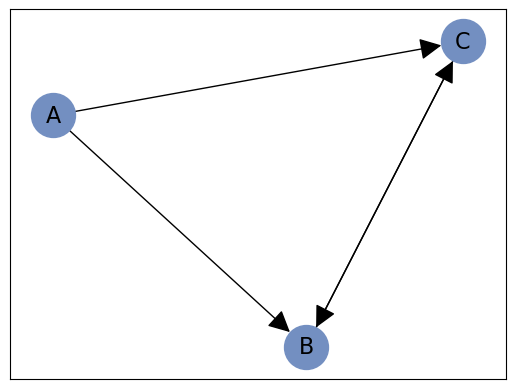

In [16]:
nx.draw_networkx(G, with_labels = True, node_size = 1000, node_color = '#738FC1', edge_color = 'black', arrowsize = 33, font_size = 16)

### The Adjacency Matrix

The adjacency matrix is a mathematical representation of a network. The adjacency matrix $\bf A$ of a graph is defined to be the $n \times n$ matrix with elements $A_{ij}$ such that 

$
A_{ij} =
\begin{cases}
1 & \text{if there is an edge between verticle } i \text{ and } j, \\
0 & \text{otherwise.}
\end{cases}
$

In [21]:
# The Adjacency Matrix can be written as follows:
A = np.array([[0, 1, 1], 
             [0, 0, 2], 
             [0, 1, 0]])

In [23]:
# Edges (or Links) with weight of a graph
Ew = [('A', 'B', 10), ('A', 'C', 5), ('B', 'C', 2), ('C', 'B', 1)]

In [25]:
Gw = nx.DiGraph()

In [27]:
pos = {'A': [0, 0], 'B': [0, 1], 'C': [1, 1]}

In [29]:
Gw.add_nodes_from(V)
Gw.add_weighted_edges_from(Ew)

In [31]:
weight = nx.get_edge_attributes(Gw, 'weight')

In [33]:
# This chunk of code is to include both weights for B and C
# Combine weights for edges between B and C & C and B
if ('B', 'C') in weight and ('C', 'B') in weight:
    weight[('B', 'C')] = f"{weight[('B', 'C')]}/{weight[('C', 'B')]}"
    del weight[('C', 'B')]  # Remove the duplicate in the reverse direction

{('A', 'B'): Text(0.0, 0.5, '10'),
 ('A', 'C'): Text(0.5, 0.5, '5'),
 ('B', 'C'): Text(0.5, 1.0, '2/1')}

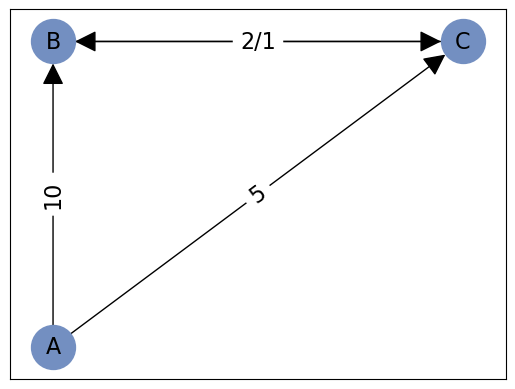

In [35]:
nx.draw_networkx(Gw, pos = pos, with_labels = True, node_size = 1000, node_color = '#738FC1', edge_color = 'black', arrowsize = 33, font_size = 16)
nx.draw_networkx_edge_labels(Gw, pos, edge_labels = weight, font_size = 16)

### The Weighted Adjacency Matrix

It is useful to represent edges as having a strength, weight, or value, usually by a real number.

In [39]:
# Write down the Adjacency Matrix
Aw = np.array([[0, 10, 5], 
             [0, 0, 2], 
             [0, 0, 1]])

In [41]:
print(Aw)

[[ 0 10  5]
 [ 0  0  2]
 [ 0  0  1]]


### Generate Features of the Graph

Generate edges and their relationships (called edge-) of $\it G$

In [45]:
nx.to_pandas_edgelist(G)

,source,target
0,A,B
1,A,C
2,B,C
3,C,B


Generate the Adjacency Matrix of $\it G$

In [48]:
nx.to_pandas_adjacency(G)

,A,B,C
A,0.0,1.0,1.0
B,0.0,0.0,1.0
C,0.0,1.0,0.0


#### Further reading: Chapter 6 from [**Networks (2nd Edition)**](https://global.oup.com/academic/product/networks-9780198805090?cc=us&lang=en&) by Mark Newman.

# PageRank

Early search engines ranked each page by using data on a page such as the number of times a search phrase appeared. The founders of Google, [Sergey Brin](https://en.wikipedia.org/wiki/Sergey_Brin)
 and [Lawrence Page](https://en.wikipedia.org/wiki/Larry_Page), came up with an alternative idea to help rank web pages while they were computer science students at Stanford. The key behind their idea, which they called [PageRank](https://en.wikipedia.org/wiki/PageRank#:~:text=PageRank%20is%20a%20way%20of,and%20the%20arrows%20represent%20hyperlinks), is that an important web page on a topic would have many other web pages linking to it. (i.e. they use the structure of the web to rank pages.) In addition to the number of links, PageRank also takes into account the importance of the linking pages. The resulting ranking is one of many factors Google uses to determine the most relevant matches for a particular query. In the following we will describe a simplified version of this PageRank algorithm.

## A Graph of A Web with 5 pages

For example, consider a collection of 5 web pages labeled $p_1$, $p_2$, $p_3$, $p_4$, and $p_5$. The links
between these web pages are shown below, where an arrow indicates that one page links to another. 

In [66]:
Gweb = nx.DiGraph()

In [68]:
Vweb = ['p1', 'p2', 'p3', 'p4', 'p5']
Eweb = [('p1', 'p2'), 
        ('p1', 'p5'), 
        ('p2', 'p3'), 
        ('p3', 'p1'), 
        ('p3', 'p4'), 
        ('p4', 'p1'), 
        ('p4', 'p2'), 
        ('p4', 'p3'),
        ('p5', 'p1'),
        ('p5', 'p2')]

In [70]:
Gweb.add_nodes_from(Vweb)
Gweb.add_edges_from(Eweb)

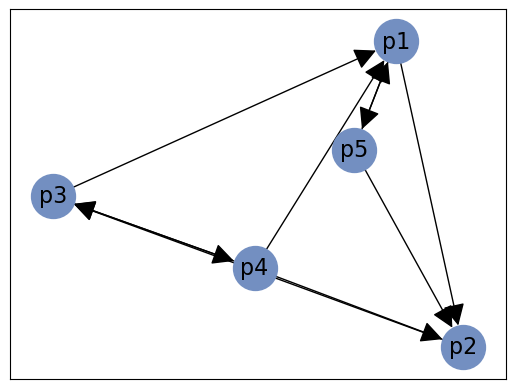

In [72]:
nx.draw_networkx(Gweb, with_labels = True, node_size = 1000, node_color = '#738FC1', edge_color = 'black', arrowsize = 33, font_size = 16)

For each web page $p_i$, the PageRank algorithm determines a rank $r_i$, which will be a numerical value indicating its importance (higher ranks being more important). 

This rank is based on two quantities we define for each page $p_i$: the number of links page $p_i$ has to other pages, which we denote by $l_i$, and the set of other pages linking to page $p_i$, which we denote by $B_i$. For example, $l_1 = 2$ and $B_1 = \{ p_3, p_4, p_5 \}$. Using these quantities, the rank of each page $p_i$ is then
given by the formula below:

\begin{align*}
r_i = (1 - d) + d \sum_{p_j \in B_i} \frac{r_j}{\ell_j}
\end{align*}


where $d$ is a design parameter chosen between 0 and 1

The ranks of the web pages are then given by the solution of this linear system of the above example.

\begin{array}{rcl}
r_1 = 0.1 & & & + 0.45r_3&  +0.3r_4 + 0.45r_5\\
r_2 = 0.1 & + 0.45r_1 & & & +0.3r_4 + 0.45r_5\\
r_3 = 0.1 & & +0.9r_2 &&  + 0.3r_4\\
r_4 = 0.1  & & & +0.45r_3\\
r_5 = 0.1 & + 0.45r_1 & & &\\
\end{array}

We can use matrix/vector notation to express these relations in the more compact form.

\begin{align*}
\mathbf{r} = (1 - d) \mathbf{1} + dH \mathbf{r}
\end{align*}


where $\textbf r$ is a $n$-dimensional vector ($n = 5$ in this case), $\mathbf{1}$ is a $5 \times 1$ vectors of all ones, and $H$ is a Hyperlink Matrix

### The Hyperlink Matrix

The Hyperlink Matrix $H$ is a $n \times n$ matrix in which the entry in the $i$-th row and the $j$-th column is given by

$
H_{ij} =
\begin{cases}
\frac{1}{{l}_{j}} & \text{if } p_{j} \in B_{i} \\
0 & \text{otherwise}
\end{cases}
$

where $l_{i}$ is the number of links page $p_{i}$ has to other pages and $B_{i}$ is the set of other pages linking to page $p_{i}$

In [3]:
H = np.array([[0, 0, 1/2, 1/3, 1/2], 
             [1/2, 0, 0, 1/3, 1/2], 
             [0, 1, 0, 1/3, 0],
             [0, 0, 1/2, 0, 0],
             [1/2, 0, 0, 0, 0]])

In [5]:
print(H)

[[0.         0.         0.5        0.33333333 0.5       ]
 [0.5        0.         0.         0.33333333 0.5       ]
 [0.         1.         0.         0.33333333 0.        ]
 [0.         0.         0.5        0.         0.        ]
 [0.5        0.         0.         0.         0.        ]]


#### The dimension of Hyperlink Matrix

In [8]:
Hdim = H.shape

In [10]:
print(Hdim)

(5, 5)


### The Adjacency Matrix

In [13]:
A_web = np.array([[0, 1, 0, 0, 1], 
             [0, 0, 1, 0, 0], 
             [1, 0, 0, 1, 0],
             [1, 1, 1, 0, 0],
             [1, 1, 0, 0, 0]])

#### What do you find the Adjacency Matrix and the Hyperlink Matrix?

In [16]:
# Hint:
AwebT = A_web.T

In [18]:
AwebT

array([[0, 0, 1, 1, 1],
       [1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0]])

## Identity Matrix

In [21]:
# The identity matrix in this case is a 5-by-5 identity matrix
I = np.eye(5)

In [23]:
print(I)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


## Initialize (an identity) Vector

Vector (in $n$ -dimension) is represented as a matrix whose number of rows is $n$ and number of column is always zero

In [27]:
one = np.ones(5)

In [29]:
print(one)

[1. 1. 1. 1. 1.]


In [31]:
one_dim = one.shape

In [33]:
print(one_dim)

(5,)


## Damping factor

In [37]:
d = 0.9

$d \in [0,1]$ 

In [40]:
# For a random d, we can use the following function np.random.rand to generate a random number between 0 and 1
d_random = np.random.rand() 
print(d_random)

0.3377306019369146


Assuming that the matrix $(I-dH)$ has an inverse, the solution of this linear system is:

\begin{align*}
\mathbf{r} = (I - dH)^{-1} (1-d)\mathbf{1}
\end{align*}


## Solve the linear system

In [67]:
# Equivalent left division in MATLAB 
r = np.linalg.solve(I - d * H, (1 - d) * one)

In [69]:
print(r)

[1.19607057 1.13517442 1.33139535 0.69912791 0.63823176]


In [71]:
highest_rank = max(r)

In [75]:
print(f'The highest rank is {highest_rank}.')

The highest rank is 1.3313953488372092.


In [77]:
print(f'The highest rank is about {round(highest_rank, 2)}.')

The highest rank is about 1.33.


## Iterative Algorithms

When applying the PageRank algorithm to the actual web, the number of pages involved can be
quite large. Moreover, even if $n$ is only a modest 10 million, then $H$ will have $n^2$ = $10^{14}$ entries!
Fortunately, most of these entries are zero, as a typical web page only links to tens or hundreds of others, not thousands or millions. For example, for this $n$, if each page links to a hundred others on average, then only 0.001% of the entries of $H$ will be nonzero. Matrices having mostly zero entries are called [**sparse matrices**](https://en.wikipedia.org/wiki/Sparse_matrix), and it is often more efficient to solve sparse systems of linear equations by using an an iterative algorithm instead of the “left division” algorithm from above. The main idea behind an iterative algorithm is to have a procedure for generating a sequence $r(0)$, $r(1)$, $r(2)$, . . . of guesses to the solution of the linear system, where at each step the previous guess is used to help make a new (and hopefully better) guess. We illustrate such a procedure by using the relation ($\mathbf{r} = (I - dH)^{-1} (1-d)\mathbf{1}$) to generate new guesses at each step. Specifically, given the $k$-th guess $r(k)$, we let the $(k + 1)$st guess be the left-hand side of the equation when the previous guess is substituted into the right-hand side

\begin{align*}
\mathbf{r}(k + 1) = (I - dH)^{-1} (1-d)\mathbf{r}(k)
\end{align*}


Note that if $r(k)$ was a solution to the linear system, then it must be that $r(k + 1) = r(k)$, i.e., if a
guess is a solution, then our rule will not change the guess.

We are interested in what happens when the guess is not a solution. To see what happens in this case, let us apply this procedure to the 5-node example above starting with an initial guess of $r(0) = \mathbf{1}$. To generate a sequence of guesses we can use the for-loop:

In [230]:
r_initial = one.copy()

In [232]:
# Print the initial step
print(f"Step 0: {r_initial}")

Step 0: [1. 1. 1. 1. 1.]


In [234]:
for k in range(1, 16):
    r_initial = (1 - d) * one + d * (H@r_initial)
    print(f"Step {k:2d}: {r_initial}")

Step  1: [1.3  1.3  1.3  0.55 0.55]
Step  2: [1.0975 1.0975 1.435  0.685  0.685 ]
Step  3: [1.2595   1.107625 1.29325  0.74575  0.593875]
Step  4: [1.17293125 1.15774375 1.3205875  0.6819625  0.666775  ]
Step  5: [1.19890188 1.13245656 1.34655813 0.69426438 0.62781906]
Step  6: [1.19674905 1.13030373 1.32749022 0.70595116 0.63950584]
Step  7: [1.19693358 1.13810005 1.32905871 0.6973706  0.63853707]
Step  8: [1.19462928 1.13517297 1.33350122 0.69807642 0.63862011]
Step  9: [1.19687752 1.13438515 1.3310786  0.70007555 0.63758318]
Step 10: [1.19592046 1.13552998 1.3309693  0.69898537 0.63859489]
Step 11: [1.19599949 1.13522752 1.33167259 0.69893619 0.63816421]
Step 12: [1.19610742 1.13505452 1.33138562 0.69925267 0.63819977]
Step 13: [1.19608923 1.13521404 1.33132487 0.69912353 0.63824834]
Step 14: [1.196045   1.13518896 1.33142969 0.69909619 0.63824015]
Step 15: [1.19608029 1.13515718 1.33139892 0.69914336 0.63822025]


The guesses generated in this manner are indeed approaching the solution we found directly in the previous section. Moreover, if we only care about the order of the ranks, then after only $k = 3$ iterations, this procedure has generated the correct order.

## Try the following exercies by yourself:

1. Create a Simple Directed Graph with at least four vertices and write down its adjacency matrix.

2. Write a function takes 3 input arguments: Number of Nodes ($N$), Number of Edges ($M$), and the damping factor ($d$) to perform a generalized the PageRank algorithm.

## References: 

Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008

Newman, M. (2018). Networks. Oxford university press.

Brin, S., & Page, L. (1998). The anatomy of a large-scale hypertextual web search engine. Computer networks and ISDN systems, 30(1-7), 107-117.